# Demo for Spherinator Training using Illustris

## Download data

the API key can be obtained from the Illustris website: https://www.tng-project.org/data/access/

To avoid hardcoding the API key in the script, you can also store it in a text file

In [3]:
import os

# ILLUSTRIS_API_KEY = "PUT HERE YOUR ILLUSTRIS API KEY"

with open(".illustris_api_key.txt", "r") as file:
    ILLUSTRIS_API_KEY = file.read().rstrip()

subhalo_ids = [454795,454898,454963,455058,455109,455198,455258,455335,455413,
               455479,455551,455637,455730,455857,455957,456014,456114,456168,
               456234,456283,456381,456456,456538,456584,456634,456725,456786,
               456872,456921,457000,457086,457169,457227,457296,457361,457452,
               457514,457604,457697,457781,457871,457931,457998,458028,458111,
               458174,458231,458302,458378,458447,458509,458604,458658,458722,
               458784,458864,458945,459020,459084,459169,459243,459270,459360,
               459394,459517,459576,459665,459730,459786,459850,459906,459959,
               460008,460076,460117,460193,460273,460351,460434,460526,460595,
               460692,460746,460823,460888,460939,461038,461136,461202,461283,
               461364,461450,461521,461609,461667,461709,461806,461864,461929,
               462010,462077,462141,462189,462241,462323,462391,462481,462564,
               462631,462690,462775,462832,462904,462986,463062,463139,463233,
               463278,463340,463395,463453,463521,463597,463649,463750,463804,
               463894,463958,464018,464110,464182,464247,464292,464331,464422,
               464490,464539,464576,464669,464742,464788,464894,464936,465016,
               465080,465136,465205,465284,465320,465361,465412,465495,465548,
               465614,465693,465764,465842,465921,466003,466055,466133,466182,
               466265,466332,466387,466436,466493,466599,466694,466746,466801,
               466894,466958,467011,467052,467127,467212,467256,467308,467385,
               467445,467519,467575,467628,467700,467740,467798,467871,467919,
               467958,468006,468064,468110,468168,468251,468318,468382,468450,
               468508,468590]

for sid in subhalo_ids:
    if os.path.exists(f"./data/illustris/fits/TNG100/sdss/snapnum_099/data/broadband_{sid}.fits"):
        continue
    !wget -nc -P ./data/illustris/fits/TNG100/sdss/snapnum_099/data --content-disposition --header="API-Key: {ILLUSTRIS_API_KEY}" "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/{sid}/skirt/broadband_sdss.fits"

## Data preparation

In [4]:
from pest import FitsConverter

image_size = 128
FitsConverter(image_size).convert_all(
    "data/illustris/fits/TNG100/sdss/snapnum_099/data", "data/illustris/parquet"
)

## Visualize training data

To get an impression of the data, we can visualize the first 50 images of the training data.

Number of data points: 200


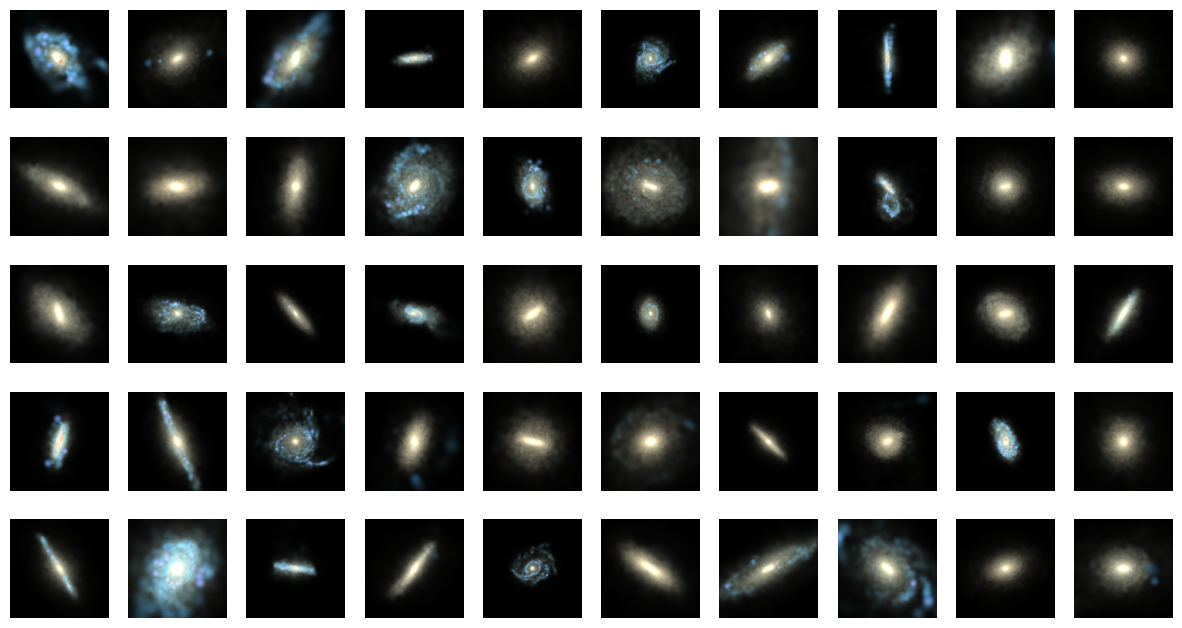

In [6]:
import pyarrow.dataset as ds
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in the notebook
%matplotlib inline

dataset = ds.dataset("data/illustris/parquet", format="parquet")
print("Number of data points:", dataset.count_rows())

df = dataset.to_table().to_pandas()

fig, axes = plt.subplots(5, 10, figsize=(15, 8))
for i, ax in enumerate(axes.flatten()):
    data = np.array(df["data"][i]).reshape(3, image_size, image_size).transpose(1, 2, 0) * 255
    image = Image.fromarray(data.astype(np.uint8), "RGB")
    ax.imshow(image)
    ax.axis("off")
plt.show()

## Training the model

In [7]:
import spherinator.models as sm

model = sm.VariationalAutoencoder(
    encoder=sm.ConvolutionalEncoder2D(
        input_dim=[3, image_size, image_size],
        output_dim=128,
        cnn_layers=[
            sm.ConsecutiveConv2DLayer(
                kernel_size=7,
                stride=1,
                padding=0,
                num_layers=5,
                base_channel_number=16,
                channel_increment=4,
            ),
            sm.ConsecutiveConv2DLayer(
                kernel_size=5,
                stride=2,
                padding=0,
                num_layers=1,
                base_channel_number=64,
            ),
            sm.ConsecutiveConv2DLayer(
                kernel_size=5,
                stride=2,
                padding=0,
                num_layers=1,
                base_channel_number=96,
            ),
            sm.ConsecutiveConv2DLayer(
                kernel_size=5,
                stride=2,
                padding=0,
                num_layers=1,
                base_channel_number=128,
            ),
        ],
    ),
    decoder=sm.ConvolutionalDecoder2D(
        input_dim=3,
        output_dim=[3, image_size, image_size],
        cnn_input_dim=[128, 36],
        cnn_layers=[
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=6,
                stride=2,
                padding=0,
                out_channels_list=[96],
            ),
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=5,
                stride=2,
                padding=0,
                out_channels_list=[64],
            ),
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=5,
                stride=2,
                padding=0,
                out_channels_list=[32],
            ),
            sm.ConsecutiveConvTranspose2DLayer(
                kernel_size=7,
                stride=1,
                padding=0,
                out_channels_list=[28, 24, 20, 16, 1],
                activation=None,
            ),
        ],
    ),
    z_dim=3,
    beta=1.0e-4,
    encoder_out_dim=128,
)
# _ = model(model.example_input_array)
# model

/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


-> use every pytorch module
-> explain the model architecture

In [ ]:
import spherinator.data as sd

datamodule = sd.ParquetDataModule(
    data_directory="data/illustris/parquet",
    data_column="data",
    normalize="minmax",
    batch_size=256,
    num_workers=4,
    shuffle=True,
)

In [9]:
import lightning.pytorch as pl

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    precision="16-mixed",
)
trainer.fit(model, datamodule=datamodule)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX 500 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set 

ArrowInvalid: No match for FieldRef.Name(flux) in data: list<element: double>
simulation: string
snapshot: string
subhalo_id: string
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string

## Export the trained model to ONNX

In [ ]:
import torch

onnx = torch.onnx.export(
    model.variational_encoder,
    torch.randn(1, 1, 343, device="cpu"),
    dynamic_axes={"input": {0: "batch"}},
    dynamo=True,
)
onnx.optimize()
onnx.save("data/illustris/models/encoder.onnx")

onnx = torch.onnx.export(
    model.decoder,
    torch.randn(1, 3, device="cpu"),
    dynamic_axes={"input": {0: "batch"}},
    dynamo=True,
)
onnx.optimize()
onnx.save("data/illustris/models/decoder.onnx")

/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:517: UserWarning: f, export_params, verbose, training, input_names, output_names, operator_export_type, opset_version, do_constant_folding, keep_initializers_as_inputs, custom_opsets, export_modules_as_functions, and autograd_inlining are not supported for dynamo export at the moment.
  warnings.warn(
/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:534: UserWarning: Specified dynamic axes is not supported for dynamo export at the moment.
  warnings.warn(
/home/doserbd/git/SPACE_HPC_Visualization_Workshop/.venv/lib/python3.12/site-packages/torch/onnx/_internal/exporter.py:137: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


OnnxExporterError: Failed to export the model to ONNX. Generating SARIF report at 'report_dynamo_export.sarif'. SARIF is a standard format for the output of static analysis tools. SARIF logs can be loaded in VS Code SARIF viewer extension, or SARIF web viewer (https://microsoft.github.io/sarif-web-component/). Please report a bug on PyTorch Github: https://github.com/pytorch/pytorch/issues

## Visualize the ONNX model with netron 

In [ ]:
!pip install -q netron
import netron
netron.start('data/illustris/models/decoder.onnx', 8081)


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Stopping http://localhost:8081
Serving 'data/gaia/models/decoder.onnx' at http://localhost:8081


('localhost', 8081)

## Pytorch Lightning Commnd Line Interface (CLI)

Start the training using a unique [yaml config-file](./configs/spherinator/illustris.yaml) in reproducible mode.

```bash
spherinator fit --c configs/spherinator/illustris.yaml
```